# $\delta_F$-vs-$\rho_{DM}$

In [3]:
import h5py
import numpy as np
from scipy.ndimage import gaussian_filter as gf
data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data_new/'
import os
import importlib
import matplotlib.pyplot as plt

def get_deltaF_deltam_est(n , z=2.4, fit_deg=2, sigma=4):
    """Estimator for each mock"""
    mockmap = np.fromfile(os.path.join(data_dir,'mock_maps_z'+str(z)+'/map_TNG_z'+str(z)+'_n'+str(n)+'.dat'))
    deltaF_mock = np.ravel(gf(mockmap.reshape(205,205,205), sigma=sigma, mode='wrap'))
    DM = np.ravel(gf(h5py.File(os.path.join(data_dir,'DM_Density_field/TNG_DM_z'+str(z)+'.hdf5'),'r')['DM/dens'][:],
                     sigma=sigma , mode='wrap'))
    co = np.polyfit(deltaF_mock, DM, fit_deg)
    
    return co

def get_deltaF_deltam_est_noiseless(z=2.4, fit_deg=2, sigma=4):
    """Estimator for each mock"""
    truemap = h5py.File(os.path.join(data_dir,'noiseless_maps/map_TNG_true_1.0_z'+str(z)+'.hdf5'),'r')['map'][:]
    deltaF_true = np.ravel(gf(truemap, sigma=sigma, mode='wrap'))
    DM = np.ravel(gf(h5py.File(os.path.join(data_dir,'DM_Density_field/TNG_DM_z'+str(z)+'.hdf5'),'r')['DM/dens'][:], 
                     sigma=sigma , mode='wrap'))
    co = np.polyfit(deltaF_true, DM, fit_deg)
    
    return co


def get_deltaF_deltam_mean_std(nmocks=20, z=2.4, fit_deg=1, sigma=4):
    """Get the mean and stdev of the estimator's parameters"""
    co_all = np.empty((nmocks, int(fit_deg+1)))
    for i,n in enumerate(np.arange(1,nmocks+1)):
        co = np.array(get_deltaF_deltam_est(n, z=z, fit_deg=fit_deg, sigma=sigma))
        co_all[i,:] = co
        
    mean = np.median(co_all, axis=0)
    std = np.std(co_all, axis=0)
    for i in range(fit_deg+1):
        print(str(np.around(mean[i],2))+'+-'+ str(np.around(std[i],2)))
    return mean, std   

In [2]:
print(get_deltaF_deltam_mean_std(z=2.3, fit_deg=2, sigma=4))
print(get_deltaF_deltam_mean_std(z=2.4, fit_deg=2, sigma=4))
print(get_deltaF_deltam_mean_std(z=2.6, fit_deg=2, sigma=4))
print(get_deltaF_deltam_mean_std(z=2.4, fit_deg=2, sigma=2))

20.78+-0.74
-6.05+-0.07
0.95+-0.01
(array([20.78180572, -6.0477379 ,  0.95247717]), array([0.74124876, 0.07350355, 0.00567408]))
16.78+-0.53
-5.62+-0.07
0.96+-0.01
(array([16.78018621, -5.61535006,  0.96007353]), array([0.52719888, 0.06522293, 0.00597003]))
15.23+-0.7
-5.44+-0.06
0.98+-0.0
(array([15.22883999, -5.43518699,  0.9828169 ]), array([0.70189474, 0.05672556, 0.00440796]))
10.58+-0.19
-4.21+-0.04
0.93+-0.0
(array([10.57712064, -4.21071756,  0.92615539]), array([0.18910044, 0.03645738, 0.00485394]))


Summarizing the estimator for the redshift bins : $ \rm \left(\frac{\rho_{\rm DM}}{\langle \rho_{\rm DM} \rangle}\right)^{sm} = a_0  \ {\delta^{sm}_F}\ {}^2 \ + \ a_1 \ \delta^{sm}_F + a_2 $

|    | $a_0$ | $a_1$ | $a_2$ |
|----|---|---| --- |
| z=2.3 | 20.78 $\pm$ 0.74| -6.05$\pm$ 0.07 | 0.95 $\pm$ 0.01|
| z=2.45 | 16.78 $\pm$ 0.53| -5.62$\pm$ 0.07 | 0.96 $\pm$ 0.01|
| z=2.6 | 15.23 $\pm$ 0.7| -5.44$\pm$ 0.06 | 0.98 $\pm$ 0.00|




The relation changes with redshift. Later here and in [this notbook](https://github.com/mahdiqezlou/LyTomo-Watershed/blob/main/notebooks/M0_Mtomo.ipynb) we show this actually does not impact the masses of the watersheds, so one can ignore the redshfit evolution of $\delta_F$-$\rho_{DM}$ relation.


Now, Write the mean and std (2d-hist) of that figure on a file : 

In [92]:
def write_mean_std_hist(z=2.4, nmocks=20):
    bins=[np.linspace(-.4,.4,100), np.linspace(0,3.5,200)]
    htot1 = np.zeros((nmocks, bins[0].size-1, bins[0].size-1))
    htot2 = np.zeros((nmocks, bins[0].size-1, bins[1].size-1))
    DM = np.ravel(gf(h5py.File(os.path.join(data_dir,'DM_Density_field/TNG_DM_z'+str(z)+'.hdf5'),'r')['DM/dens'][:], 
                     sigma=4 , mode='wrap'))
    
    for i,n in enumerate(np.arange(1,nmocks+1)):
        mockmap = np.fromfile(os.path.join(data_dir,'mock_maps_z'+str(z)+'/map_TNG_z'+str(z)+'_n'+str(n)+'.dat'))
        deltaF_mock = np.ravel(gf(mockmap.reshape(205,205,205), 4, mode='wrap'))
        with h5py.File(os.path.join(data_dir,'noiseless_maps/map_TNG_true_1.0_z'+str(z)+'.hdf5'),'r') as ftrue :
            deltaF_true = np.ravel(gf(ftrue['map'][:], 4, mode='wrap'))
        deltaF_true *= np.std(deltaF_mock)/np.std(deltaF_true)
        h1,_, _ = np.histogram2d(deltaF_mock, deltaF_true, bins=[bins[0],bins[0]], density=True)
        h2, _, _= np.histogram2d(deltaF_mock, DM, bins=bins, density=True)
        
        htot1[i,:,:] = h1
        htot2[i,:,:] = h2
    with h5py.File(os.path.join(data_dir,'plotting_data/df_mock_true_dm_z'+str(z)+'.hdf5'),'w') as fw:
        fw['df_mock_true/median'] = np.median(htot1, axis=0)
        fw['df_mock_true/std'] = np.std(htot1, axis=0)
        fw['df_dm/median'] = np.median(htot2, axis=0)
        fw['df_dm/std'] = np.std(htot2, axis=0)
    
def write_hist_noiseless(z=2.4):
    bins=[np.linspace(-.4,.4,100), np.linspace(0,3.5,200)]
    noiseless_map = h5py.File(os.path.join(data_dir,'noiseless_maps/map_TNG_true_1.0_z'+str(z)+'.hdf5'),'r')['map'][:]
    deltaF_true = np.ravel(gf(noiseless_map, 4, mode='wrap'))
    DM = np.ravel(gf(h5py.File(os.path.join(data_dir,'DM_Density_field/TNG_DM_z'+str(z)+'.hdf5'),'r')['DM/dens'][:], 4 , mode='wrap'))
    h,_, _ = np.histogram2d(deltaF_true, DM, bins=[bins[0],bins[1]], density=True)
    with h5py.File(os.path.join(data_dir,'plotting_data/df_dm_true_z'+str(z)+'.hdf5'),'w') as fw:
        fw['df_dm'] = h


In [59]:
write_hist_noiseless(z=2.4)

In [85]:
write_mean_std_hist(z=2.4)

In [7]:
def plot_for_deltaF_deltam(data_dir):
    from lytomo_watershed import plot
    importlib.reload(plot)
    dfdm = plot.Df_dm(data_dir=data_dir)
    
    left, width = .2, .7
    bottom2, height2 = 0.5, 0.4
    bottom1, height1 = .1, .4

    rect_scatter1 = [left, bottom1, width, height1]
    rect_scatter2 = [left, bottom2, width, height2]

    fig = plt.figure(figsize=(8, 16))
    ax = []
    ax.append(fig.add_axes(rect_scatter1))
    ax.append(fig.add_axes(rect_scatter2))
    ax[1].tick_params(axis="x", labelbottom=False)
    dfdm.deltaF_true_mock(fig, ax, z=2.4)
    x = np.arange(-0.4,0.4,0.01)


    #ax[1].plot(x, np.polyval([14.56817442, -4.96863497,  0.96664919], x), label='z=2.3', color='C2')
    ax[1].plot(x, np.polyval([16.78018621, -5.61535006,  0.96007353],x), label='Power-law estimator', color='C1')
    #ax[1].plot(x, np.polyval([10.1530904 , -4.37489626,  0.99182931], x), label='z=2.6', ls='--', color='C3')
    ax[1].legend(loc=(0,-.05), facecolor='w')
    fig.savefig('../figures/deltam_deltaF_z2.4.pdf', transparent=False)

No handles with labels found to put in legend.


<KeysViewHDF5 ['df_dm', 'df_mock_true']>


/run/media/mahdi/HD2/package_dev/LyTomo_Watershed/src/lytomo_watershed/plot.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


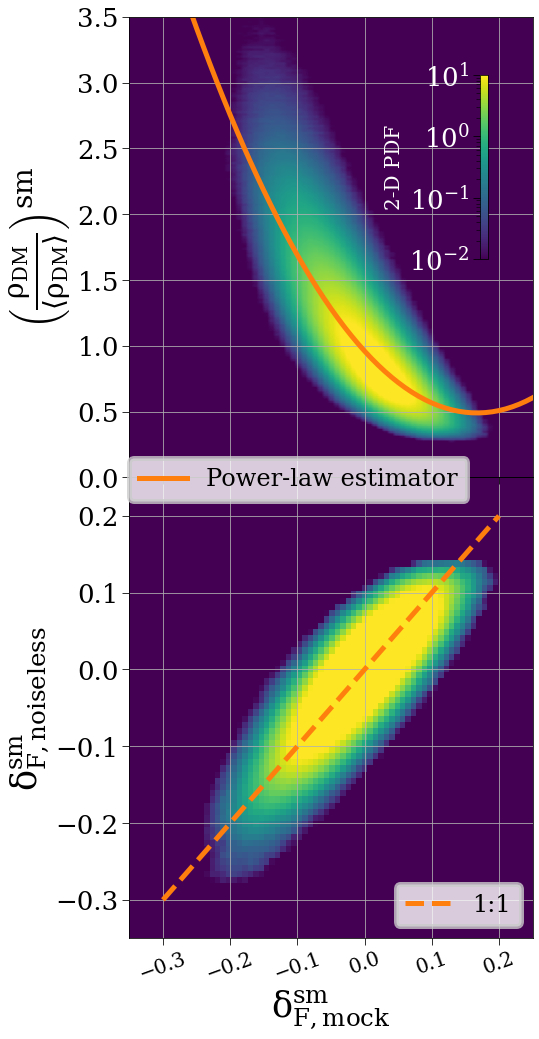

In [9]:
plot_for_deltaF_deltam(data_dir)

# $M_{DM}$-vs-$M_{tomo}$:


In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import importlib
plt.style.use('./paper.mystyle')

def find_optimal_offset(ax, Mtomo, MDM, ls, label):
    offset_range = np.arange(0,1,0.0001)
    err = np.array([])
    for offset in offset_range:
        dev = MDM - (Mtomo+offset)
        err = np.append(err, np.sqrt(np.mean(dev*dev)))
    ind = np.where(err == np.min(err))
    print('Minimum error is at offset = ', offset_range[ind])
    ax.plot(offset_range, err, ls=ls, label=label)

In [5]:
def load_watersheds(n, z, th, lc, data_dir):
    with h5py.File(os.path.join(data_dir,'watersheds_z'+str(z)+'/mocks/n'+str(n)
                   +'/labeled_map_TNG_z'+str(z)+'_n'+str(n)
                   +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                   +'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5'),'r') as f:
        lmap_mock = f['map'][:]
    peaks_mock = h5py.File(os.path.join(data_dir,'watersheds_z'+str(z)+'/mocks/n'
                                        +str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)
                                        +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                                        +'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5'), 'r')
    with h5py.File(os.path.join(data_dir,'watersheds_z'+str(z)+'/noiseless/labeled_map_TNG_true_z'
                                +str(z)+'_n1_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'
                                +str(np.around(lc,2)).ljust(4,'0')+'.hdf5'),'r') as f :
        lmap_true = f['map'][:]
    peaks_true = h5py.File(os.path.join(data_dir,'watersheds_z'+str(z)+'/noiseless/peaks_TNG_true_z'
                                        +str(z)+'_n1_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                                        +'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5'),'r')
    return lmap_mock, peaks_mock, lmap_true, peaks_true
    

In [6]:
def write_data(z_accurate = 2.4442257045541464, z=2.4, th=2.35, lc=2.00, offset=0.1414):
    """Writes the Mtomo and Dm masses on a file since they are slow to produce"""
    from lytomo_watershed import minima
    importlib.reload(minima)
    fname = (os.path.join(data_dir,'plotting_data/Mtomo_MDM_z'+str(z)+'_th'+str(th).ljust(4,'0')
                          +'_lc'+str(lc).ljust(4,'0')+'.hdf5'))
    DM_file = os.path.join(data_dir,'DM_Density_field/TNG_DM_z'+str(z)+'.hdf5')
    with h5py.File(fname,'w') as fw:
        for n in range(1,21):
            lmap_mock, peaks_mock, lmap_true, peaks_true = load_watersheds(n=n,z=z,th=th,lc=lc, data_dir=data_dir)
            Mtomo_mock, Mtomo_true, MDM_mock, MDM_true, MDM_mock_true, id_max_overlap = minima.get_Mtomo_MDM(z_accurate=z_accurate, lmap_mock=lmap_mock,
                                                                                                             lmap_true=lmap_true, peaks_mock=peaks_mock, 
                                                                                                             peaks_true=peaks_true, DM_file=DM_file)
            fw[str(n)+'/Mtomo_mock'] = Mtomo_mock[:]+offset
            fw[str(n)+'/MDM_mock'] = MDM_mock[:]
            fw[str(n)+'/Mtomo_mock_overlap'] = Mtomo_mock[:][id_max_overlap['mock'][:].astype(int)-1]+offset
            fw[str(n)+'/MDM_true_overlap'] = MDM_mock_true
            fw[str(n)+'/id_max_overlap/mock'] = id_max_overlap['mock'][:]
            fw[str(n)+'/id_max_overlap/true'] = id_max_overlap['true'][:]

In [60]:
def plot_for_paper(n, z, th, lc, co=(0.40,14.50), vmin=0.01, vmax=1e2):
    """plot the M_DM vs M_tomo for paper"""
    import os
    from lytomo_watershed import plot
    importlib.reload(plot)
    
    data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data_new/'
    mass_file = os.path.join(data_dir,'plotting_data/Mtomo_MDM_z'+str(z)
                             +'_th'+str(th).ljust(4,'0')+'_lc'+str(lc).ljust(4,'0')
                             +'.hdf5')
    Mtomo_MDM = plot.Mtomo_MDM(mass_file=mass_file)
    
    signif = h5py.File(os.path.join(data_dir,'watersheds_z'+str(z)+'/mocks/n'
                                    +str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)
                                    +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                                    +'_lc'+str(np.around(lc,2)).ljust(4,'0')
                                    +'.hdf5'), 'r')['signif'][:]
        
    f = h5py.File(mass_file,'r')
    fig, ax = plt.subplots(1,2, figsize=(18,9))

    Mtomo_MDM.plot_Mtomo_MDM(fig, ax[0], f[str(n)+'/Mtomo_mock'][:], f[str(n)+'/MDM_mock'][:],
                             z=z, th= th, lc=lc, signif=signif, mass_file= mass_file, 
                             xlabel=r'$\rm log [ M_{tomo} ]$', ylabel=r'$\rm log [ M_{DM, mock}]$',
                             legend=False, plot_kde=True, first_plot=True, vmin=vmin, vmax=vmax)

    #signif = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5', 'r')['signif'][:]
    signif = signif[f[str(n)+'/id_max_overlap/mock'][:].astype(int)-1]

    Mtomo_MDM.plot_Mtomo_MDM(fig, ax[1], f[str(n)+'/Mtomo_mock_overlap'][:],
                             f[str(n)+'/MDM_true_overlap'][:], z=z, th=th, 
                             lc=lc, signif=signif, mass_file=mass_file, co=co, legend=True, 
                             plot_kde=True, first_plot=False)
    
    f.close()
    plt.tight_layout(pad=0)
    return fig

## For $z=2.3, 2.4, 2.6$ and $\nu = -2.0$, $\kappa = -2.35$ :

### Find optimal offset in $M_{tomo}$:
First, we need to find the best offset introduced in equation 7 in [the paper](https://arxiv.org/pdf/2112.03930.pdf).

Find the optimal offset needed to get the Mtomo close to MDM within same waterhseds in mock maps.

In [27]:
def get_offset():
    import os
    from lytomo_watershed import minima
    data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data_new/'
    z, z_acc, ls= [2.4], [2.4442257045541464], ['--', 'solid', 'dotted']
    fig, ax = plt.subplots()
    ax.set_xlabel('offset (dex)')
    ax.set_ylabel(r'$ rms \ [ M_{tomo, raw} - M_{DM, mock}]$')
    for i in range(1):
        DM = h5py.File(os.path.join(data_dir,'DM_Density_field/TNG_DM_z'
                                    +str(z[i])+'.hdf5'),'r')['DM/dens'][:]
        lmap_mock, peaks_mock, lmap_true, peaks_true = load_watersheds(z=z[i], n=1, th=2.35, lc=2.00)
        Mtomo_mock, _, MDM_mock, _, _, _ = minima.get_Mtomo_MDM(z_accurate=z_acc[i], lmap_mock=lmap_mock,
                                                               lmap_true=lmap_true, peaks_mock=peaks_mock,
                                                               peaks_true=peaks_true, DM=DM)

        find_optimal_offset(ax, Mtomo_mock, MDM_mock, ls=ls[i], label='z='+str(z[i]))
    ax.legend()

Minimum error is at offset =  [0.1414]


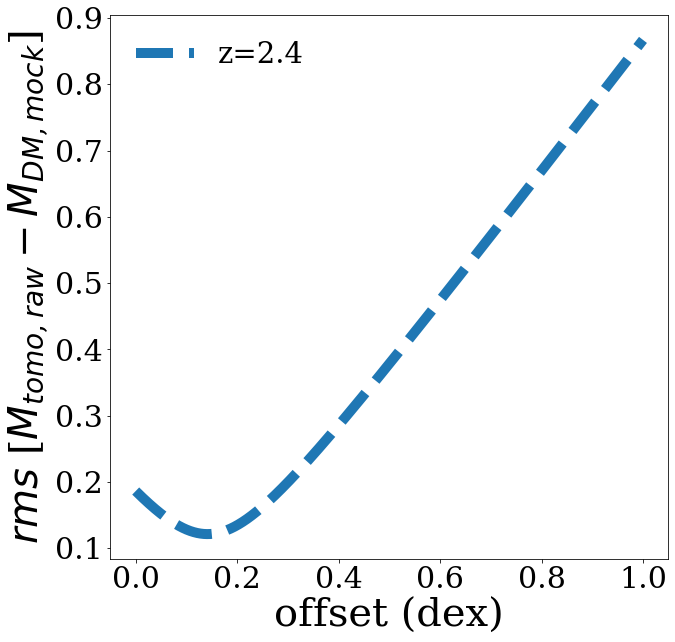

In [28]:
get_offset()

- The offset (0.142 dex) is insensitive to the variations in $\delta_F$-vs-$\rho_{DM}$ estimator. 

Write the data on file for later ease. It stores the $M_{tomo}$ and $M_{DM}$ for 20 of mock maps.

**Note** : Each line in the cell below takes ~ 3 minutes to run, so it is a bit slow. \
The data already exists in `./LyTomo_data/plotting_data/`, so if you wish, you can skip running the next cell.

In [ ]:
write_data(z=2.4, z_accurate=2.4442257045541464, th=2.35, lc=2.00, offset=0.142)

Below we find the mean power-law estimators and comapre the $M_{tomo}$ with $M_{DM}$. 


### z = 2.4:

Mean estimator:

In [9]:
def get_the_fit(z):
    from lytomo_watershed import plot
    data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data_new/'
    importlib.reload(plot)
    mass_file = os.path.join(data_dir,'plotting_data/Mtomo_MDM_z'+str(z)+'_th2.35_lc2.00.hdf5')
    Mtomo_plot = plot.Mtomo_MDM(mass_file=mass_file)
    #ntrain, co = plot_different_fits(mass_file = os.path.join(data_dir,'plotting_data/Mtomo_MDM_z2.4_th2.35_lc2.00.hdf5'), z=2.4, th=2.35, lc=2.00)
    ntrain, co = Mtomo_plot.plot_different_fits(z=z, th=2.35, lc=2.00)
    ntest = np.arange(1,21)[np.in1d(np.arange(1,21), ntrain, invert=True)]
    print(Mtomo_plot.test_fit(co=co, ntest=ntest, z=z, th=2.35, lc=2.00))

Slope :  0.386+-0.069
Intercept :  14.59+-0.051
[0.3243382728238666, 0.32918401119384516, 0.30393044302561123]


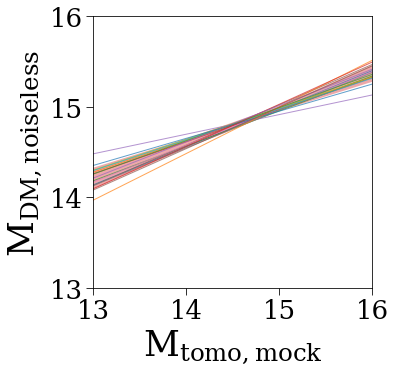

In [39]:
get_the_fit(z=2.4)

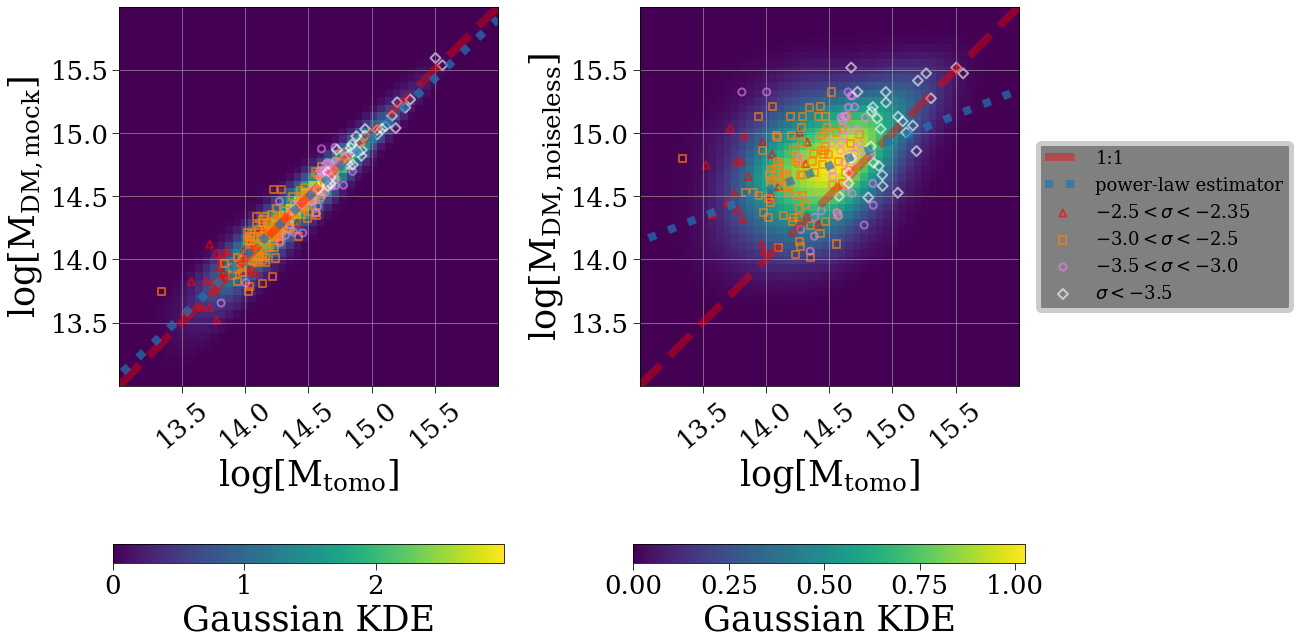

In [46]:
fig = plot_for_paper(n=1, z=2.4, th=2.35, lc=2.00, co=(0.40,14.54), vmin=0.2, vmax=1)
fig.savefig('../figures/Mtomo_mock_MDM_true_kde.pdf')

### z=2.3 :

Mean estimator:

Find the mean power-law estimator among the 20 mock maps. 

In [ ]:
write_data(z=2.3, z_accurate=2.3161107439568918, th=2.35, lc=2.00, offset=0.142)

Slope :  0.425+-0.089
Intercept :  14.59+-0.062
[0.3990306872301181, 0.4119541928315669, 0.31674431229999667]


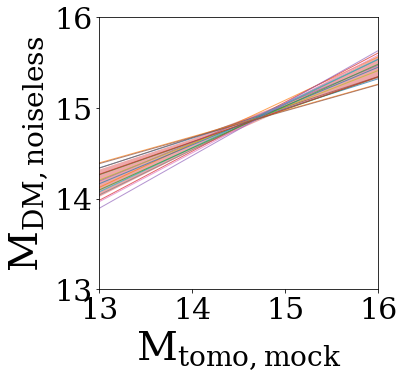

In [15]:
get_the_fit(z=2.3)

### z=2.6:
Mean estimator :

In [37]:
write_data(z=2.6, z_accurate=2.5772902716018935, th=2.35, lc=2.00, offset=0.142)

Slope :  0.340+-0.051
Intercept :  14.63+-0.035
[0.3711971093567169, 0.3106035588031311, 0.31287460945206397]


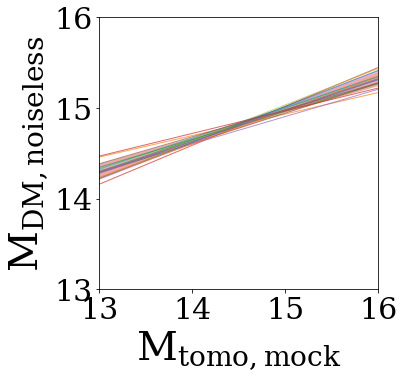

In [27]:
get_the_fit(z=2.6)

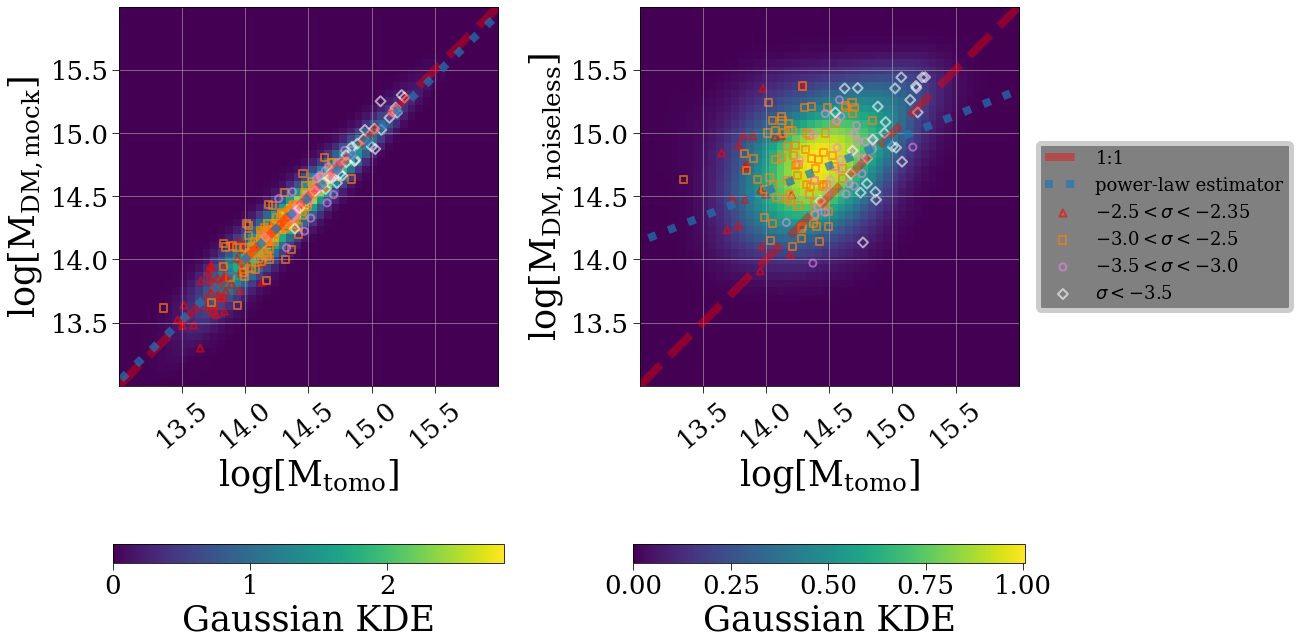

In [61]:
fig = plot_for_paper(n=1, z=2.6, th=2.35, lc=2.00, co=(0.40,14.54), vmin=0.2, vmax=1)

|z | # Watersheds | slope | intercept |
|--|--|--| --|
|2.3|  | 0.43+-0.09 | 14.59+-0.06|
|2.4|  | 0.39+-0.07 | 14.60+-0.05|
|2.6|  | 0.34+-0.06 | 14.63+-0.04|

- We found the estimators for $M_{DM}$-vs-$M_{tomo}$ realtion and the scatter around them.

- Our estimator and the scatter around it is not changed whether we use the same $\delta_F$-vs-$\rho_{DM}$ estimator or not. So, we can use the mid-redshift parameters for the entire map.

In [this notebook](https://github.com/mahdiqezlou/LyTomo-Watershed/blob/main/notebooks/M0_Mtomo.ipynb), we show the estimators for $M_{desc}$-vs-$M_{tomo}$ stays the same too.